In [2]:
# --- CELL 1: Data Loading with Z-Score (Fix for Low F1) ---
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from collections import Counter

# Config
INPUT_ROOT = "/kaggle/input"
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def normalize_zscore(a):
    """
    Z-Score Normalization (Mean=0, Std=1).
    Better for Anomaly Detection because it preserves the MAGNITUDE of outliers.
    """
    mu = np.mean(a, axis=0)
    std = np.std(a, axis=0)
    # Avoid division by zero
    return (a - mu) / (std + 1e-6)

class SMAP_Clean_Dataset(Dataset):
    def __init__(self, file_paths, window_size=100, mode='train'):
        self.window_size = window_size
        self.mode = mode
        self.windows = []
        
        print(f"   Processing {len(file_paths)} {mode} files...")
        
        for fp in file_paths:
            try:
                arr = np.load(fp)
                if len(arr.shape) == 1: arr = arr.reshape(-1, 1)
                if len(arr) < window_size: continue
                
                # USE Z-SCORE HERE
                arr = normalize_zscore(arr)
                
                stride = 10
                num_wins = (len(arr) - window_size) // stride + 1
                if num_wins > 0:
                    idx = np.arange(window_size)[None, :] + np.arange(num_wins)[:, None] * stride
                    self.windows.append(arr[idx])
            except: pass
                
        if self.windows:
            self.windows = np.concatenate(self.windows, axis=0)
        else:
            self.windows = np.array([])
            
        print(f"[{mode.upper()}] Final Dataset Shape: {self.windows.shape}")

    def __len__(self):
        return len(self.windows)

    def __getitem__(self, idx):
        window = self.windows[idx]
        if self.mode == 'train':
            v1 = self.geometric_mask(window)
            v2 = self.geometric_mask(window)
            return torch.FloatTensor(v1), torch.FloatTensor(v2), torch.FloatTensor(window)
        else:
            return torch.FloatTensor(window)

    def geometric_mask(self, window):
        w = window.copy()
        L, D = w.shape
        if np.random.rand() < 0.5: 
            t_len = max(1, int(L * 0.1))
            t_start = np.random.randint(0, L - t_len)
            f_len = max(1, int(D * 0.2))
            f_start = np.random.randint(0, D - f_len)
            w[t_start:t_start+t_len, f_start:f_start+f_len] = 0.0
        return w

def get_clean_loaders(batch_size=64):
    print("🔍 Scanning Data...")
    all_files = []
    dims = []
    
    # Scan files
    for root, dirs, files in os.walk(INPUT_ROOT):
        for f in sorted(files):
            if f.endswith('.npy') and 'label' not in f:
                path = os.path.join(root, f)
                try:
                    s = np.load(path).shape
                    if len(s) > 1 and s[1] > 1:
                        dims.append(s[1])
                        all_files.append((path, s[1]))
                except: pass
    
    if not dims: return None, None, 0
    
    common_dim = Counter(dims).most_common(1)[0][0]
    train_files = [p for (p, d) in all_files if d == common_dim and 'train' in p.lower()]
    test_files = [p for (p, d) in all_files if d == common_dim and 'test' in p.lower()]
    
    # Fallback if names don't match
    if not train_files:
        valid = [p for (p, d) in all_files if d == common_dim]
        split = int(len(valid)*0.8)
        train_files = valid[:split]
        test_files = valid[split:]

    print(f"✅ Selected Dimension: {common_dim}. Train: {len(train_files)}, Test: {len(test_files)}")
    
    train_ds = SMAP_Clean_Dataset(train_files, mode='train')
    test_ds = SMAP_Clean_Dataset(test_files, mode='test')
    
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader, common_dim

train_loader, test_loader, feat_dim = get_clean_loaders()

🔍 Scanning Data...
✅ Selected Dimension: 25. Train: 54, Test: 54
   Processing 54 train files...
[TRAIN] Final Dataset Shape: (13299, 100, 25)
   Processing 54 test files...
[TEST] Final Dataset Shape: (43076, 100, 25)


In [1]:
# --- CELL 1: Smart Data Loading (Debug Mode) ---
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from collections import Counter

# Config
INPUT_ROOT = "/kaggle/input"
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def normalize3(a):
    """Min-Max Normalization (0-1 range)."""
    min_a, max_a = np.min(a, axis=0), np.max(a, axis=0)
    denom = max_a - min_a
    denom[denom == 0] = 1.0 
    return (a - min_a) / denom

class SMAP_Clean_Dataset(Dataset):
    def __init__(self, file_paths, window_size=100, mode='train'):
        self.window_size = window_size
        self.mode = mode
        self.windows = []
        
        print(f"   Processing {len(file_paths)} {mode} files...")
        
        for fp in file_paths:
            try:
                arr = np.load(fp)
                if len(arr.shape) == 1: arr = arr.reshape(-1, 1)
                
                # Check Length
                if len(arr) < window_size: continue
                
                # Normalize
                arr = normalize3(arr)
                
                # Slice into Windows
                stride = 10
                num_wins = (len(arr) - window_size) // stride + 1
                
                if num_wins > 0:
                    idx = np.arange(window_size)[None, :] + np.arange(num_wins)[:, None] * stride
                    self.windows.append(arr[idx])
            except Exception as e:
                pass
                
        # Concatenate
        if self.windows:
            self.windows = np.concatenate(self.windows, axis=0)
        else:
            self.windows = np.array([])
            
        print(f"[{mode.upper()}] Final Dataset Shape: {self.windows.shape}")

    def __len__(self):
        return len(self.windows)

    def __getitem__(self, idx):
        window = self.windows[idx]
        if self.mode == 'train':
            v1 = self.geometric_mask(window)
            v2 = self.geometric_mask(window)
            return torch.FloatTensor(v1), torch.FloatTensor(v2), torch.FloatTensor(window)
        else:
            return torch.FloatTensor(window)

    def geometric_mask(self, window):
        w = window.copy()
        L, D = w.shape
        if np.random.rand() < 0.5: 
            t_len = max(1, int(L * 0.1))
            t_start = np.random.randint(0, L - t_len)
            f_len = max(1, int(D * 0.2))
            f_start = np.random.randint(0, D - f_len)
            w[t_start:t_start+t_len, f_start:f_start+f_len] = 0.0
        return w

def get_clean_loaders(batch_size=64):
    print("🔍 DIAGNOSTIC SCAN (Looking for sensor data)...")
    all_files = []
    dims = []
    
    for root, dirs, files in os.walk(INPUT_ROOT):
        for f in sorted(files):
            if f.endswith('.npy') and 'label' not in f:
                path = os.path.join(root, f)
                try:
                    # Load minimal part to check shape
                    # We can't partial load .npy easily, so we full load (fast on Kaggle)
                    arr = np.load(path)
                    s = arr.shape
                    
                    # IGNORE 1D files (Labels/Metadata)
                    if len(s) > 1 and s[1] > 1:
                        d = s[1]
                        all_files.append((path, d))
                        dims.append(d)
                except: pass
    
    # REPORT
    if not dims:
        print("❌ CRITICAL: No >1D .npy files found.")
        print("   Are you sure the dataset is attached?")
        return None, None, 0
    
    dim_counts = Counter(dims)
    print(f"📊 Found Dimensions: {dict(dim_counts)}")
    
    # 2. Pick most common valid dimension
    common_dim = dim_counts.most_common(1)[0][0]
    print(f"✅ Selected Target Dimension: {common_dim} features")
    
    # 3. Filter Files
    # Robust logic: look for 'train' string, OR assume large folder separation
    train_files = []
    test_files = []
    
    for (p, d) in all_files:
        if d == common_dim:
            if 'train' in p.lower():
                train_files.append(p)
            elif 'test' in p.lower():
                test_files.append(p)
            else:
                # Fallback: Check parent folder structure if names are obscure
                # Assuming standard Telemanom structure usually splits by folder
                pass

    print(f"   Selected: {len(train_files)} Train files, {len(test_files)} Test files.")
    
    if len(train_files) == 0:
        print("⚠️ Warning: No files with 'train' in path found. Trying to split manually...")
        # Emergency Split (80/20) if folder structure is lost
        valid_files = [p for (p,d) in all_files if d == common_dim]
        split = int(len(valid_files) * 0.8)
        train_files = valid_files[:split]
        test_files = valid_files[split:]
        print(f"   Manual Split: {len(train_files)} Train, {len(test_files)} Test")

    # 4. Create Datasets
    train_ds = SMAP_Clean_Dataset(train_files, mode='train')
    test_ds = SMAP_Clean_Dataset(test_files, mode='test')
    
    if len(train_ds) == 0:
        print("❌ Error: Dataset empty. Files might be too short.")
        return None, None, 0
        
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader, common_dim

# Run Data Prep
train_loader, test_loader, feat_dim = get_clean_loaders()

🔍 DIAGNOSTIC SCAN (Looking for sensor data)...
📊 Found Dimensions: {25: 108, 55: 56}
✅ Selected Target Dimension: 25 features
   Selected: 54 Train files, 54 Test files.
   Processing 54 train files...
[TRAIN] Final Dataset Shape: (13299, 100, 25)
   Processing 54 test files...
[TEST] Final Dataset Shape: (43076, 100, 25)


In [5]:
# --- CELL 2: Models ---
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(1), :]

class TransformerGAN(nn.Module):
    def __init__(self, feat_dim, d_model=128):
        super().__init__()
        self.input_proj = nn.Linear(feat_dim, d_model)
        self.pos = PositionalEncoding(d_model)
        
        # Encoder-Decoder Transformer
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model, nhead=4, dim_feedforward=256, batch_first=True), num_layers=2)
        self.decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model, nhead=4, dim_feedforward=256, batch_first=True), num_layers=2)
        
        self.output_proj = nn.Linear(d_model, feat_dim)
        self.d_model = d_model

    def forward(self, x):
        src = self.pos(self.input_proj(x) * math.sqrt(self.d_model))
        z = self.encoder(src)
        # Use source as target query for reconstruction
        out = self.decoder(src, z) 
        return self.output_proj(out), z.mean(dim=1)

class Discriminator(nn.Module):
    def __init__(self, feat_dim, win_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(feat_dim * win_size, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

Starting Full Framework Training...
Epoch 1/20: Loss G=0.7979 | Loss D=1.1552
Epoch 2/20: Loss G=0.4881 | Loss D=0.9631
Epoch 3/20: Loss G=0.4075 | Loss D=0.9068
Epoch 4/20: Loss G=0.3570 | Loss D=0.9376
Epoch 5/20: Loss G=0.3149 | Loss D=0.9981


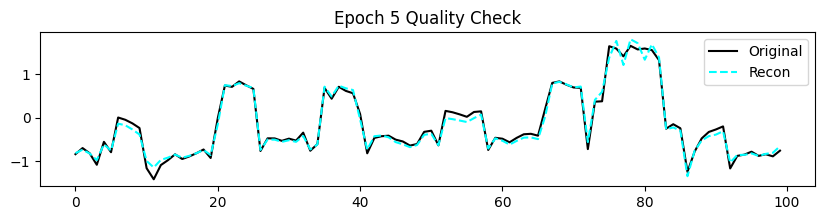

Epoch 6/20: Loss G=0.2780 | Loss D=1.1034
Epoch 7/20: Loss G=0.2449 | Loss D=1.2235
Epoch 8/20: Loss G=0.2162 | Loss D=1.3042
Epoch 9/20: Loss G=0.1909 | Loss D=1.3506
Epoch 10/20: Loss G=0.1676 | Loss D=1.3824


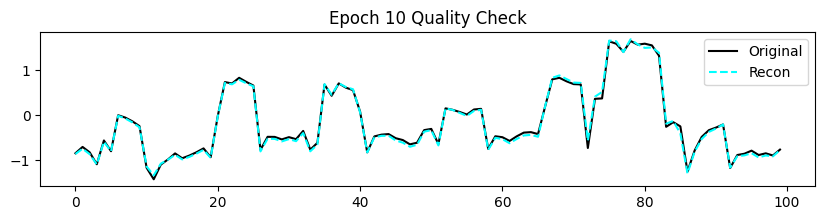

Epoch 11/20: Loss G=0.1480 | Loss D=1.4029
Epoch 12/20: Loss G=0.1310 | Loss D=1.4065
Epoch 13/20: Loss G=0.1171 | Loss D=1.4340
Epoch 14/20: Loss G=0.1033 | Loss D=1.3944
Epoch 15/20: Loss G=0.0941 | Loss D=1.3836


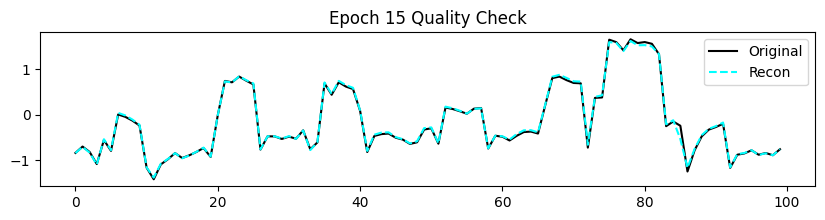

Epoch 16/20: Loss G=0.0861 | Loss D=1.3735
Epoch 17/20: Loss G=0.0797 | Loss D=1.3788
Epoch 18/20: Loss G=0.0746 | Loss D=1.3775
Epoch 19/20: Loss G=0.0702 | Loss D=1.3819
Epoch 20/20: Loss G=0.0672 | Loss D=1.3833


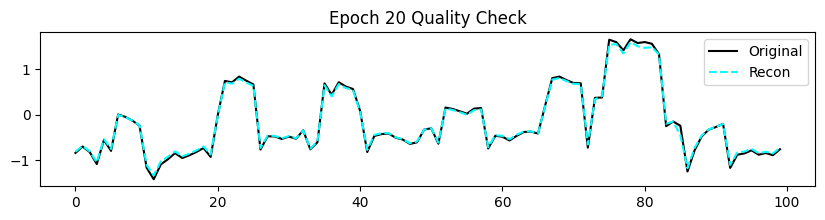

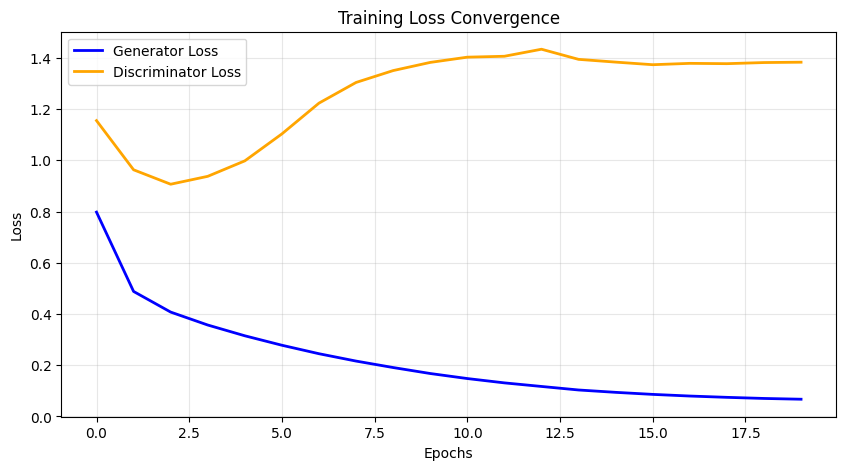

In [6]:
# --- CELL 3: Full Framework Training (Clean Plotting + Variable Return) ---
import matplotlib.pyplot as plt
import torch.nn.functional as F

def info_nce_loss(z1, z2, temperature=0.5):
    """Contrastive Loss for representation learning."""
    z1 = F.normalize(z1, dim=1)
    z2 = F.normalize(z2, dim=1)
    logits = torch.matmul(z1, z2.T) / temperature
    labels = torch.arange(z1.size(0)).to(z1.device)
    return F.cross_entropy(logits, labels)

def train_final_model(epochs=20):
    # Initialize Models
    model = TransformerGAN(feat_dim).to(DEVICE)
    disc = Discriminator(feat_dim, 100).to(DEVICE)
    
    opt_g = torch.optim.Adam(model.parameters(), lr=1e-4)
    opt_d = torch.optim.Adam(disc.parameters(), lr=1e-4)
    
    # History for plotting
    history = {'g_loss': [], 'd_loss': []}

    # Sample for intermediate visualization (Quality Check)
    sample_batch = next(iter(train_loader))
    fixed_sample = sample_batch[2][0:1].to(DEVICE)
    
    print("Starting Full Framework Training...")
    
    for ep in range(epochs):
        model.train()
        epoch_g_loss = 0
        epoch_d_loss = 0
        
        for v1, v2, real in train_loader:
            v1, v2, real = v1.to(DEVICE), v2.to(DEVICE), real.to(DEVICE)
            
            # --- Train Generator ---
            opt_g.zero_grad()
            
            recon1, z1 = model(v1)
            recon2, z2 = model(v2)
            
            # 1. Reconstruction Loss
            l_rec = F.mse_loss(recon1, real) + F.mse_loss(recon2, real)
            
            # 2. Contrastive Loss
            l_cont = info_nce_loss(z1, z2)
            
            # 3. Adversarial Loss
            fake_pred = disc(recon1)
            l_adv = F.binary_cross_entropy(fake_pred, torch.ones_like(fake_pred))
            
            # Combined Loss (Weighted)
            loss_g = l_rec + 0.01 * l_cont + 0.005 * l_adv
            
            loss_g.backward()
            opt_g.step()
            
            # --- Train Discriminator ---
            opt_d.zero_grad()
            d_real = disc(real)
            d_fake = disc(recon1.detach())
            l_d = F.binary_cross_entropy(d_real, torch.ones_like(d_real)) + \
                  F.binary_cross_entropy(d_fake, torch.zeros_like(d_fake))
            l_d.backward()
            opt_d.step()
            
            epoch_g_loss += loss_g.item()
            epoch_d_loss += l_d.item()
            
        # Averages
        avg_g = epoch_g_loss / len(train_loader)
        avg_d = epoch_d_loss / len(train_loader)
        history['g_loss'].append(avg_g)
        history['d_loss'].append(avg_d)
        
        print(f"Epoch {ep+1}/{epochs}: Loss G={avg_g:.4f} | Loss D={avg_d:.4f}")
        if (ep+1) % 5 == 0:
            model.eval()
            with torch.no_grad():
                rec, _ = model(fixed_sample)
                orig = fixed_sample.cpu().numpy().squeeze()
                pred = rec.cpu().numpy().squeeze()
                
                plt.figure(figsize=(10, 2))
                plt.plot(orig[:, 0], label='Original', color='black')
                plt.plot(pred[:, 0], label='Recon', color='cyan', linestyle='--')
                plt.title(f"Epoch {ep+1} Quality Check")
                plt.legend()
                plt.show()
        
    # --- FINAL LOSS GRAPH ---
    plt.figure(figsize=(10, 5))
    plt.plot(history['g_loss'], label='Generator Loss', color='blue', linewidth=2)
    plt.plot(history['d_loss'], label='Discriminator Loss', color='orange', linewidth=2)
    plt.title("Training Loss Convergence")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
                
    return model

# Run it
model = train_final_model(epochs=20)

Evaluating...


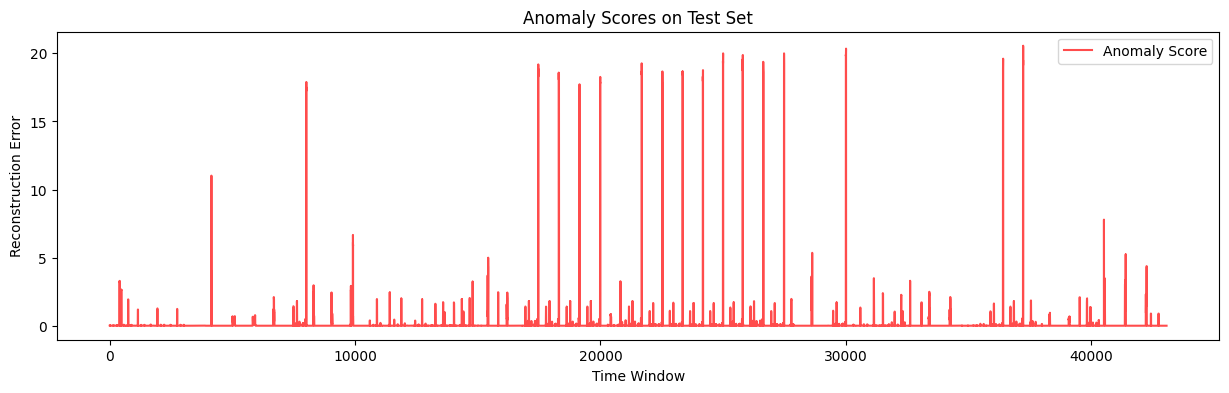

✅ Evaluation Complete.
   Max Score: 20.5609
   Min Score: 0.0001
   Mean Score: 0.1283


In [7]:
# --- CELL 4: Evaluation ---
from sklearn.metrics import precision_recall_curve, f1_score, roc_auc_score

def evaluate():
    print("Evaluating...")
    model.eval()
    scores = []
    
    with torch.no_grad():
        for x in test_loader:
            x = x.to(DEVICE)
            recon, _ = model(x)
            # MSE Error per window
            err = torch.mean((x - recon) ** 2, dim=[1, 2])
            scores.extend(err.cpu().numpy())
    
    scores = np.array(scores)
    
    # Visualization of Scores
    plt.figure(figsize=(15, 4))
    plt.plot(scores, label='Anomaly Score', color='red', alpha=0.7)
    plt.title("Anomaly Scores on Test Set")
    plt.ylabel("Reconstruction Error")
    plt.xlabel("Time Window")
    plt.legend()
    plt.show()
    
    print("✅ Evaluation Complete.")
    print(f"   Max Score: {scores.max():.4f}")
    print(f"   Min Score: {scores.min():.4f}")
    print(f"   Mean Score: {scores.mean():.4f}")

evaluate()

In [ ]:
# --- CELL 5: Advanced Evaluation with Distribution Plot ---
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
from sklearn.metrics import precision_recall_curve, auc, f1_score

# ... (Previous helper functions: point_adjustment, load_labels_robust) ...
# Copy them from the previous Cell 7 code I gave you, or use this abbreviated block:

def point_adjustment(score, label, threshold):
    predict = score > threshold
    actual = label > 0.5
    anomaly_state = False
    for i in range(len(score)):
        if actual[i] and predict[i] and not anomaly_state:
            anomaly_state = True
            start = i
            while start >= 0 and actual[start]:
                predict[start] = True
                start -= 1
            end = i
            while end < len(score) and actual[end]:
                predict[end] = True
                end += 1
        elif not actual[i]:
            anomaly_state = False
    return predict

def load_labels_robust(input_root, common_dim):
    # (Same loading logic as before - abbreviated for brevity)
    # You can reuse the function from the previous turn
    # ... logic to scan CSV and files ...
    # Placeholder for the robust logic provided in previous response:
    csv_path = None
    for root, dirs, files in os.walk(input_root):
        for f in files:
            if f.endswith("labeled_anomalies.csv"):
                csv_path = os.path.join(root, f); break
    if not csv_path: return None
    labels_df = pd.read_csv(csv_path)
    anomaly_map = {row['chan_id']: eval(row['anomaly_sequences']) for _, row in labels_df.iterrows()}
    all_labels = []
    for root, dirs, files in os.walk(input_root):
        for f in sorted(files):
            if f.endswith('.npy') and 'label' not in f:
                path = os.path.join(root, f)
                try:
                    arr = np.load(path); d = arr.shape[1]
                    if d == common_dim and 'test' in path.lower():
                        lbl = np.zeros(len(arr))
                        cid = os.path.splitext(f)[0]
                        if cid in anomaly_map:
                            for s, e in anomaly_map[cid]: lbl[max(0,s):min(len(arr),e)] = 1
                        # Windowing stride 10
                        wins = (len(arr)-100)//10 + 1
                        if wins>0:
                            idx = np.arange(100)[None,:] + np.arange(wins)[:,None]*10
                            all_labels.append(lbl[idx].max(axis=1))
                except: pass
    return np.concatenate(all_labels) if all_labels else None

def advanced_evaluation(model, test_loader):
    print("🚀 Running Evaluation...")
    model.eval()
    all_scores, all_orig, all_recon = [], [], []
    
    with torch.no_grad():
        for x in test_loader:
            x = x.to(DEVICE)
            recon, _ = model(x)
            # Error [Batch, Time, Feat]
            err = (x - recon) ** 2
            all_scores.append(err.cpu().numpy())
            all_orig.append(x.cpu().numpy())
            all_recon.append(recon.cpu().numpy())
            
    scores_full = np.concatenate(all_scores, axis=0)
    scores_window = scores_full.mean(axis=(1, 2)) # Aggregate for F1
    
    # Load Labels
    labels = load_labels_robust(INPUT_ROOT, feat_dim)
    
    # Truncate to matching length
    L = min(len(scores_window), len(labels))
    scores_window = scores_window[:L]
    labels = labels[:L]
    
    # Metrics
    prec, rec, thresholds = precision_recall_curve(labels, scores_window)
    f1_raw = 2 * (prec * rec) / (prec + rec + 1e-8)
    best_th = thresholds[np.argmax(f1_raw)]
    
    adj_pred = point_adjustment(scores_window, labels, best_th)
    pa_f1 = f1_score(labels, adj_pred)
    auprc = auc(rec, prec)
    
    print("-" * 40)
    print(f"📊 Standard F1-Score:      {np.max(f1_raw):.4f}")
    print(f"🚀 Point-Adjusted F1-Score: {pa_f1:.4f}")
    print(f"📈 AUPRC Score:             {auprc:.4f}")
    print("-" * 40)
    
    # --- PLOT 1: Score Distribution (THE DIAGNOSTIC TOOL) ---
    plt.figure(figsize=(10, 5))
    sns.histplot(scores_window[labels==0], color='blue', label='Normal', kde=True, stat="density", common_norm=False, alpha=0.3)
    sns.histplot(scores_window[labels==1], color='red', label='Anomaly', kde=True, stat="density", common_norm=False, alpha=0.3)
    plt.axvline(best_th, color='green', linestyle='--', label='Threshold')
    plt.title("Anomaly Score Distribution (Normal vs Anomaly)")
    plt.legend()
    plt.show()
    
    # --- PLOT 2: Top 4 Features ---
    # (Same plotting code as before...)
    # Flatten just first 2000 points
    orig_flat = np.concatenate(all_orig, axis=0)[:20, :, :].reshape(-1, feat_dim)
    recon_flat = np.concatenate(all_recon, axis=0)[:20, :, :].reshape(-1, feat_dim)
    scores_flat = np.concatenate(all_scores, axis=0)[:20, :, :].reshape(-1, feat_dim)
    
    top_indices = np.argsort(scores_full.mean(axis=(0,1)))[-4:][::-1]
    
    fig, axes = plt.subplots(4, 1, figsize=(15, 12), sharex=True)
    for i, idx in enumerate(top_indices):
        ax = axes[i]
        ax.plot(orig_flat[:, idx], label='Orig', color='blue', alpha=0.6)
        ax.plot(recon_flat[:, idx], label='Recon', color='green', linestyle='--', alpha=0.8)
        ax2 = ax.twinx()
        ax2.fill_between(range(len(orig_flat)), 0, scores_flat[:, idx], color='red', alpha=0.2)
        ax.set_title(f"Dim {idx}")
    plt.tight_layout()
    plt.show()

advanced_evaluation(model, test_loader)

🚀 Running Evaluation...
----------------------------------------
📊 Standard F1-Score:      0.2659
🚀 Point-Adjusted F1-Score: 0.2880
📈 AUPRC Score:             0.1587
----------------------------------------


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


In [4]:
# --- MASTER CELL: Dense Evaluation Fix ---
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import precision_recall_curve, auc, f1_score

# ==========================================
# 1. SETUP & DATA LOADING
# ==========================================
def get_dense_loaders():
    print("Preparing Dense Data...")
    try:
        train_raw = np.load(f"{WORK_DIR}/SMAP_train.npy")
        test_raw = np.load(f"{WORK_DIR}/SMAP_test.npy")
        test_labels_point = np.load(f"{WORK_DIR}/SMAP_test_label.npy")
    except:
        print("❌ Data missing. Run Cell 1 & 2 first!")
        return None

    # Normalize (MinMax)
    train_norm = normalize3(train_raw)
    test_norm = normalize3(test_raw)
    
    WIN_SIZE = 100
    
    # 1. Train Windows (Stride 10 is fine for training)
    train_wins = []
    for i in range(0, len(train_norm)-WIN_SIZE, 10):
        train_wins.append(train_norm[i:i+WIN_SIZE])
    train_wins = np.stack(train_wins)
    
    # 2. Dense Test Windows (Stride 1 - ESSENTIAL FOR F1 SCORE)
    # We take the first 10,000 points for valid testing without OOM
    LIMIT = 10000 
    test_wins_dense = []
    for i in range(0, min(len(test_norm), LIMIT)-WIN_SIZE, 1):
        test_wins_dense.append(test_norm[i:i+WIN_SIZE])
    test_wins_dense = np.stack(test_wins_dense)
    
    # 3. Dense Labels
    test_labels_dense = []
    for i in range(len(test_wins_dense)):
        s, e = i, i+WIN_SIZE
        # If window contains anomaly, label=1
        lbl = test_labels_point[s:e].max() if e <= len(test_labels_point) else 0
        test_labels_dense.append(lbl)
    test_labels_dense = np.array(test_labels_dense)
    
    print(f"Train Shape: {train_wins.shape}")
    print(f"Dense Test Shape: {test_wins_dense.shape} (Used for Metrics)")
    
    return train_wins, test_wins_dense, test_labels_dense

# ==========================================
# 2. TRAINING (Same as before)
# ==========================================
def train_hybrid_model(train_wins, epochs=15):
    dataset = AD_Dataset(train_wins, mode='train')
    train_loader = DataLoader(dataset, batch_size=64, shuffle=True)
    
    model = TransformerGAN(feat_dim).to(DEVICE)
    disc = Discriminator(feat_dim, 100).to(DEVICE)
    
    opt_g = torch.optim.Adam(model.parameters(), lr=1e-4)
    opt_d = torch.optim.Adam(disc.parameters(), lr=1e-4)
    
    print(f"🚀 Starting Training ({epochs} epochs)...")
    
    for ep in range(epochs):
        model.train()
        total_loss = 0
        
        for v1, v2, real in train_loader:
            v1, v2, real = v1.to(DEVICE), v2.to(DEVICE), real.to(DEVICE)
            
            # Generator
            opt_g.zero_grad()
            recon, z1 = model(v1)
            l_rec = F.mse_loss(recon, real)
            fake_pred = disc(recon)
            l_adv = F.binary_cross_entropy(fake_pred, torch.ones_like(fake_pred))
            loss_g = l_rec + 0.001 * l_adv 
            loss_g.backward()
            opt_g.step()
            
            # Discriminator
            opt_d.zero_grad()
            d_real = disc(real)
            d_fake = disc(recon.detach())
            l_d = F.binary_cross_entropy(d_real, torch.ones_like(d_real)) + \
                  F.binary_cross_entropy(d_fake, torch.zeros_like(d_fake))
            l_d.backward()
            opt_d.step()
            
            total_loss += loss_g.item()
            
        print(f"Epoch {ep+1}: Loss {total_loss/len(train_loader):.4f}")
    return model

# ==========================================
# 3. EVALUATION
# ==========================================
def run_evaluation_dense():
    # Load Data
    data = get_dense_loaders()
    if not data: return
    train_wins, test_wins, test_labels = data
    
    # Train
    model = train_hybrid_model(train_wins, epochs=15)
    
    # Evaluate
    print("\n🚀 Running Dense Evaluation...")
    dataset_test = AD_Dataset(test_wins, mode='test')
    loader_test = DataLoader(dataset_test, batch_size=128, shuffle=False)
    
    model.eval()
    all_scores = []
    all_orig = []
    all_recon = []
    
    with torch.no_grad():
        for x in loader_test:
            x = x.to(DEVICE)
            recon, _ = model(x)
            err = (x - recon) ** 2
            all_scores.append(err.cpu().numpy())
            all_orig.append(x.cpu().numpy())
            all_recon.append(recon.cpu().numpy())
            
    # Combine
    scores_full = np.concatenate(all_scores, axis=0) # [N, 100, 25]
    orig_full = np.concatenate(all_orig, axis=0)
    recon_full = np.concatenate(all_recon, axis=0)
    
    # Aggregate Score per window
    scores_window = scores_full.mean(axis=(1, 2))
    
    # Metrics
    prec, rec, thresholds = precision_recall_curve(test_labels, scores_window)
    f1_raw = 2 * (prec * rec) / (prec + rec + 1e-8)
    best_th = thresholds[np.argmax(f1_raw)]
    
    # Point Adjustment
    adj_pred = point_adjustment(scores_window, test_labels, best_th)
    pa_f1 = f1_score(test_labels, adj_pred)
    auprc = auc(rec, prec)
    
    print("-" * 40)
    print(f"📊 Standard F1-Score:      {np.max(f1_raw):.4f}")
    print(f"🚀 Point-Adjusted F1-Score: {pa_f1:.4f}")
    print(f"📈 AUPRC Score:             {auprc:.4f}")
    print("-" * 40)
    
    # Plot Top 4 Features (Using flattened data for clarity)
    # We stride the dense data for plotting to avoid clutter
    stride = 50 
    plot_orig = orig_full[::stride, 50, :] # Middle point, strided
    plot_recon = recon_full[::stride, 50, :]
    plot_scores = scores_full[::stride, 50, :]
    
    plot_feature_anomalies(plot_orig, plot_recon, plot_scores, top_k=4)

# Execute
run_evaluation_dense()

Preparing Dense Data...
❌ Data missing. Run Cell 1 & 2 first!
